
Rastrigin: 2D


In [1]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=8269c21af9f4a856142023537433bb198a08794f6a9436df41b0caf48bc57a07
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Rastrigin'
Beta_CBM = 1.0

n_test = 500
eps = 1e-08

util_grad_exact = 'dCBM_GP'
util_grad_approx = 'CBM'

n_init = 5 # random initialisations
iters = 20
opt = True

In [4]:
### Objective Function - Rastrigin(x) 2-D:

def objfunc(x1_training, x2_training):
        return  operator * (10 * dim + x1_training** 2 - 10 * np.cos(2 * np.pi * x1_training)
                                    + x2_training** 2 - 10 * np.cos(2 * np.pi * x2_training)
                          )
        
def objfunc_der(x1_training, x2_training):
        return  operator * (2 * x1_training + 20 * np.pi * np.sin(2 * np.pi * x1_training)
                                    + 2 * x2_training + 20 * np.pi * np.sin(2 * np.pi * x2_training)
                          )
    
# Constraints:
lb = -5.12 
ub = +5.12
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# True y bounds:
operator = -1
y_global_orig = 0 # targets global minimum

# Test data:
x1_test = np.linspace(lb, ub, n_test) 
x2_test = np.linspace(lb, ub, n_test)
  
x_test = np.column_stack((x1_test,x2_test))


In [5]:
n_start_AcqFunc = iters


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds
        

In [8]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBM': self.CBM,
            'dCBM_GP': self.dCBM_GP
        }

        self.f = mode_dict[mode]

    def CBM(self, tau, mean, std):
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (z + np.sqrt(Beta_CBM))

    def dCBM_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## GPGO_multi: Multistart changed to variable 'n_start_AcqFunc'

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        if self.n_jobs == 1:
            for index, start_point in enumerate(start_points_arr):
                res = minimize(self._acqWrapper, x0=start_point, method=method,
                               bounds=self.parameter_range)
                x_best[index], f_best[index] = res.x, np.atleast_1d(res.fun)[0]
        else:
            opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self._acqWrapper,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
            x_best = np.array([res.x for res in opt])
            f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.best = x_best[np.argmin(f_best)]

In [10]:
## dGPGO:

grad = 1

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1643624691.7148736

In [13]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_new(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.84969467  2.25612281]. 	  -20.33436270766351 	 -19.908403246996286
init   	 [-5.1188288  -2.02411446]. 	  -33.07414982069084 	 -19.908403246996286
init   	 [-3.61721968 -4.17445279]. 	  -53.347974723929894 	 -19.908403246996286
init   	 [-3.21269544 -1.58145816]. 	  -39.218472310354045 	 -19.908403246996286
init   	 [-1.05710106  0.39748336]. 	  -19.908403246996286 	 -19.908403246996286
1      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -19.908403246996286
2      	 [4.59783526 5.12      ]. 	  -68.2341694500779 	 -19.908403246996286
3      	 [-5.12  5.12]. 	  -57.849427451571785 	 -19.908403246996286
4      	 [ 4.14382952 -0.05906844]. 	  -21.668644686804747 	 -19.908403246996286
5      	 [ 0.90022341 -3.6890489 ]. 	  -30.057813278786526 	 -19.908403246996286
6      	 [0.71816038 5.12      ]. 	  -41.42769286642552 	 -19.908403246996286
7      	 [-5.12        1.53252656]. 	  -51.065240907156316 	 -19.908403246996286
8  

In [14]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_new(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.6554122  -4.85451539]. 	  -43.490296251903594 	 -18.964539418712707
init   	 [ 0.50854377 -0.6622987 ]. 	  -35.91861667536101 	 -18.964539418712707
init   	 [-0.81543371 -1.73737143]. 	  -20.479562046739524 	 -18.964539418712707
init   	 [-3.02439799  1.2213347 ]. 	  -18.964539418712707 	 -18.964539418712707
init   	 [-2.05153614 -2.3876887 ]. 	  -28.041315668371354 	 -18.964539418712707
1      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -18.964539418712707
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -18.964539418712707
3      	 [-0.09462468  5.12      ]. 	  -30.649629876625823 	 -18.964539418712707
4      	 [5.12       0.07753192]. 	  -30.09400720521394 	 -18.964539418712707
5      	 [-5.12  5.12]. 	  -57.849427451571785 	 -18.964539418712707
6      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -18.964539418712707
7      	 [2.34176113 2.48334218]. 	  -47.0474779545132 	 -18.964539418712707
8      	 [-5.12      -1.2337

In [15]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_new(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.52017052 2.1314337 ]. 	  -27.953858411008774 	 -10.607662635789808
init   	 [-2.14113547  0.11087468]. 	  -10.607662635789808 	 -10.607662635789808
init   	 [4.02377681 4.05804123]. 	  -33.42749829480097 	 -10.607662635789808
init   	 [-3.83400642 -2.99783293]. 	  -28.650953928965198 	 -10.607662635789808
init   	 [-4.59297584 -0.6061072 ]. 	  -57.6631355589384 	 -10.607662635789808
1      	 [ 5.12       -3.40646859]. 	  -58.85106049996051 	 -10.607662635789808
2      	 [-5.12  5.12]. 	  -57.849427451571785 	 -10.607662635789808
3      	 [ 0.46120886 -5.12      ]. 	  -48.84186852202956 	 -10.607662635789808
4      	 [5.12       0.49378339]. 	  -49.160908281034565 	 -10.607662635789808
5      	 [ 1.47945946 -1.42536887]. 	  -43.05787311599592 	 -10.607662635789808
6      	 [-1.23867572  5.12      ]. 	  -39.74810629461169 	 -10.607662635789808
7      	 [-3.18942775  2.50539298]. 	  -42.729050817966346 	 -10.60766263578

In [16]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = GaussianProcess(cov_func, optimize=opt)

approx_4 = GPGO_multi(surrogate_approx_4, Acquisition_new(util_grad_approx), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.78238555 0.48365823]. 	  -51.03163809010808 	 -14.323038259018315
init   	 [4.84028785 2.19971578]. 	  -39.78645699016559 	 -14.323038259018315
init   	 [ 2.02474316 -2.90724357]. 	  -14.323038259018315 	 -14.323038259018315
init   	 [ 4.87705042 -5.05620219]. 	  -52.80627247106233 	 -14.323038259018315
init   	 [-2.52946061 -0.66773471]. 	  -41.61497868486559 	 -14.323038259018315
1      	 [-5.12  5.12]. 	  -57.849427451571785 	 -14.323038259018315
2      	 [0.36025788 5.12      ]. 	  -45.441215505148605 	 -14.323038259018315
3      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -14.323038259018315
4      	 [-0.95956577 -5.12      ]. 	  -30.16646976605881 	 -14.323038259018315
5      	 [0.85383055 1.14538088]. 	  -9.85993426995825 	 -9.85993426995825
6      	 [-5.12        1.50099315]. 	  -51.17749947176581 	 -9.85993426995825
7      	 [3.91388146 5.12      ]. 	  -45.671749290456205 	 -9.85993426995825
8      	 [-1.97864

In [17]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = GaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_new(util_grad_approx), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.84678993  3.79629882]. 	  -33.93442008827236 	 -7.8108627039749745
init   	 [-3.00319585  4.2865757 ]. 	  -39.673876075575784 	 -7.8108627039749745
init   	 [-0.11866943  1.14425716]. 	  -7.8108627039749745 	 -7.8108627039749745
init   	 [2.72289645 0.1886002 ]. 	  -25.38160395721669 	 -7.8108627039749745
init   	 [-2.08076286 -3.19773462]. 	  -22.589982116319675 	 -7.8108627039749745
1      	 [ 5.12       -4.99275306]. 	  -53.862661721714915 	 -7.8108627039749745
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -7.8108627039749745
3      	 [-5.12      -0.0462623]. 	  -29.346346365124056 	 -7.8108627039749745
4      	 [1.00367613 5.12      ]. 	  -29.93474692248845 	 -7.8108627039749745
5      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -7.8108627039749745
6      	 [ 1.11157798 -5.12      ]. 	  -32.518763703851306 	 -7.8108627039749745
7      	 [ 5.12       -1.57430137]. 	  -50.333046404759706 	 -7.8108627039749745
8    

In [18]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = GaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_new(util_grad_approx), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 4.02288795 -1.72052679]. 	  -31.08835710146886 	 -17.28954482757088
init   	 [ 3.28938622 -4.69302655]. 	  -58.797867722203385 	 -17.28954482757088
init   	 [-4.0175956   0.97333314]. 	  -17.28954482757088 	 -17.28954482757088
init   	 [ 0.30532979 -0.83141193]. 	  -19.296253155889353 	 -17.28954482757088
init   	 [-1.68542362  1.25459899]. 	  -28.650630936276173 	 -17.28954482757088
1      	 [5.12 5.12]. 	  -57.849427451571785 	 -17.28954482757088
2      	 [-4.81188345 -4.71436937]. 	  -63.80856959161615 	 -17.28954482757088
3      	 [-5.12  5.12]. 	  -57.849427451571785 	 -17.28954482757088
4      	 [0.39539537 5.12      ]. 	  -46.99780280466514 	 -17.28954482757088
5      	 [-0.75149581 -5.12      ]. 	  -39.39547677174894 	 -17.28954482757088
6      	 [2.84228176 1.91251751]. 	  -17.730550035104265 	 -17.28954482757088
7      	 [-2.70420983 -2.00942761]. 	  -24.205641920986555 	 -17.28954482757088
8      	 [5.12   

In [19]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = GaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_new(util_grad_approx), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.33860312  2.86636843]. 	  -45.646133072936244 	 -22.52235437888213
init   	 [-0.63068947  2.28828342]. 	  -34.83012662845338 	 -22.52235437888213
init   	 [4.8946126  0.39419771]. 	  -44.09657005662876 	 -22.52235437888213
init   	 [ 0.01147355 -4.38219639]. 	  -36.613209822404315 	 -22.52235437888213
init   	 [-2.37118484e+00 -1.20319155e-03]. 	  -22.52235437888213 	 -22.52235437888213
1      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -22.52235437888213
2      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -22.52235437888213
3      	 [3.59133267 5.12      ]. 	  -60.22050074241665 	 -22.52235437888213
4      	 [-4.02558214 -1.33646422]. 	  -33.289738493146906 	 -22.52235437888213
5      	 [ 1.40596253 -0.96124904]. 	  -21.50032775704576 	 -21.50032775704576
6      	 [-1.80774326  5.12      ]. 	  -38.64360730531317 	 -21.50032775704576
7      	 [2.33742834 2.1303982 ]. 	  -28.396102910207063 	 -21.50032775704576
8      	 [

In [20]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = GaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_new(util_grad_approx), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.82391708 4.79785639]. 	  -50.20079446939181 	 -13.871821018360485
init   	 [3.78055209 0.31596228]. 	  -36.5114251593508 	 -13.871821018360485
init   	 [-2.73686192 -5.00327624]. 	  -43.34985765011677 	 -13.871821018360485
init   	 [-0.7119993  -0.99992207]. 	  -13.871821018360485 	 -13.871821018360485
init   	 [ 0.23218863 -0.22126801]. 	  -17.190590355445654 	 -13.871821018360485
1      	 [-5.12  5.12]. 	  -57.849427451571785 	 -13.871821018360485
2      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -13.871821018360485
3      	 [-5.12       -0.06301435]. 	  -29.70230475253388 	 -13.871821018360485
4      	 [-0.66935012  4.17606833]. 	  -38.26086123857408 	 -13.871821018360485
5      	 [ 1.18396998 -4.40964488]. 	  -45.247264906595284 	 -13.871821018360485
6      	 [-2.62634408  1.70415101]. 	  -39.65401080570149 	 -13.871821018360485
7      	 [1.62780943 2.34346397]. 	  -40.627490394561065 	 -13.871821018360485
8      

In [21]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = GaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_new(util_grad_approx), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.01376866  0.01919582]. 	  -25.248289026162446 	 -24.454800313488693
init   	 [-0.04328148 -3.74958562]. 	  -24.454800313488693 	 -24.454800313488693
init   	 [-3.66478248 -2.88195916]. 	  -39.46509426509438 	 -24.454800313488693
init   	 [-0.83447623 -2.57944404]. 	  -31.06766397812992 	 -24.454800313488693
init   	 [-4.25922917 -1.58209393]. 	  -49.922543556206975 	 -24.454800313488693
1      	 [3.57043636 5.12      ]. 	  -60.70929224547916 	 -24.454800313488693
2      	 [ 5.12       -0.52152104]. 	  -49.105413994412324 	 -24.454800313488693
3      	 [-2.48124797  5.12      ]. 	  -55.01197484016164 	 -24.454800313488693
4      	 [ 4.68633807 -5.12      ]. 	  -64.7806589955877 	 -24.454800313488693
5      	 [0.61721516 1.56463223]. 	  -39.424071710437204 	 -24.454800313488693
6      	 [-5.12       3.1519978]. 	  -43.08396388335738 	 -24.454800313488693
7      	 [ 2.24770004 -1.78403998]. 	  -25.96792231251058 	 -24.

In [22]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = GaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_new(util_grad_approx), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.77832339 -4.90750004]. 	  -41.674330194390116 	 -13.839458310244165
init   	 [1.36855793 2.54775176]. 	  -44.69639719065837 	 -13.839458310244165
init   	 [-0.01528819 -2.81808235]. 	  -13.839458310244165 	 -13.839458310244165
init   	 [-3.09183626  2.66783449]. 	  -33.23221510904937 	 -13.839458310244165
init   	 [-3.38830503 -4.2154003 ]. 	  -54.73014366983691 	 -13.839458310244165
1      	 [ 5.12       -0.56839857]. 	  -48.338444720486976 	 -13.839458310244165
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -13.839458310244165
3      	 [-5.12       -0.60617868]. 	  -47.148108983687465 	 -13.839458310244165
4      	 [-5.12  5.12]. 	  -57.849427451571785 	 -13.839458310244165
5      	 [-0.83793368  5.12      ]. 	  -34.37864693575814 	 -13.839458310244165
6      	 [-1.23133836 -0.10553597]. 	  -12.47660679647689 	 -12.47660679647689
7      	 [ 1.89650272 -0.792677  ]. 	  -13.616536585583749 	 -12.47660679647689
8    

In [23]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = GaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_new(util_grad_approx), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.27403839 -4.92057353]. 	  -47.655641290890955 	 -10.679755252484755
init   	 [-0.37664229  2.30332343]. 	  -35.87889240695259 	 -10.679755252484755
init   	 [-0.81711509 -0.14922651]. 	  -10.679755252484755 	 -10.679755252484755
init   	 [-4.98912446 -0.12931474]. 	  -28.05462905574235 	 -10.679755252484755
init   	 [4.52410012 3.59214172]. 	  -71.62694632141611 	 -10.679755252484755
1      	 [ 5.12       -4.32842605]. 	  -62.39062688396604 	 -10.679755252484755
2      	 [-5.12  5.12]. 	  -57.849427451571785 	 -10.679755252484755
3      	 [ 0.92603922 -5.12      ]. 	  -30.84274333525805 	 -10.679755252484755
4      	 [ 3.11715539 -0.55364603]. 	  -32.04960003303037 	 -10.679755252484755
5      	 [1.2098287 5.12     ]. 	  -37.89107696992745 	 -10.679755252484755
6      	 [-1.93527424  5.12      ]. 	  -33.485624217055346 	 -10.679755252484755
7      	 [-0.92580818 -2.63129356]. 	  -25.633820376672066 	 -10.67975525248

In [24]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = GaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_new(util_grad_approx), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.54137249  2.45810889]. 	  -57.903242869085595 	 -40.51116653209555
init   	 [-2.42365424  0.34549139]. 	  -40.51116653209555 	 -40.51116653209555
init   	 [-4.97075238  4.28796936]. 	  -55.62655915398208 	 -40.51116653209555
init   	 [ 4.10332011 -4.77776458]. 	  -49.962803461970296 	 -40.51116653209555
init   	 [ 4.6791612  -3.71497655]. 	  -62.183891474990624 	 -40.51116653209555
1      	 [5.12 5.12]. 	  -57.849427451571785 	 -40.51116653209555
2      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -40.51116653209555
3      	 [2.51311923 0.83225821]. 	  -32.03308276955943 	 -32.03308276955943
4      	 [0.33251829 5.12      ]. 	  -43.99086697503873 	 -32.03308276955943
5      	 [-0.4860359  -4.11888169]. 	  -39.82534541070362 	 -32.03308276955943
6      	 [-5.12       -1.54445624]. 	  -50.92247146624271 	 -32.03308276955943
7      	 [ 5.12       -0.37888454]. 	  -46.30979721549848 	 -32.03308276955943
8      	 [ 1.638342

In [25]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = GaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_new(util_grad_approx), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.84367268 -2.68757791]. 	  -33.58019830007169 	 -17.435826639425656
init   	 [3.32061217 4.76927179]. 	  -56.857057997503354 	 -17.435826639425656
init   	 [ 4.83943541 -0.47667971]. 	  -48.211919361679726 	 -17.435826639425656
init   	 [1.11659482 2.82139151]. 	  -17.435826639425656 	 -17.435826639425656
init   	 [1.45012065 2.27346667]. 	  -38.25352329493884 	 -17.435826639425656
1      	 [-5.12       -2.72639272]. 	  -47.83578724999891 	 -17.435826639425656
2      	 [-5.12  5.12]. 	  -57.849427451571785 	 -17.435826639425656
3      	 [-1.07703278 -5.12      ]. 	  -31.233358362285884 	 -17.435826639425656
4      	 [-2.85646815  1.12648428]. 	  -16.221862594672384 	 -16.221862594672384
5      	 [-1.15501594  5.12      ]. 	  -34.63877027990219 	 -16.221862594672384
6      	 [-0.62079669 -1.40886561]. 	  -38.030492873307395 	 -16.221862594672384
7      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -16.221862594672384
8   

In [26]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = GaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_new(util_grad_approx), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.14277984 2.79721013]. 	  -18.683085263052178 	 -10.423838604848608
init   	 [ 3.7931795  -5.03759925]. 	  -47.36348784446708 	 -10.423838604848608
init   	 [-1.94830412  4.68586229]. 	  -40.19779334078636 	 -10.423838604848608
init   	 [ 0.13431513 -1.86076749]. 	  -10.423838604848608 	 -10.423838604848608
init   	 [ 0.40140736 -2.85434939]. 	  -30.353548735049138 	 -10.423838604848608
1      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -10.423838604848608
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -10.423838604848608
3      	 [-5.12        0.35475585]. 	  -45.16750766638469 	 -10.423838604848608
4      	 [ 5.12       -0.06383876]. 	  -29.72251027870363 	 -10.423838604848608
5      	 [-5.12  5.12]. 	  -57.849427451571785 	 -10.423838604848608
6      	 [-1.64775397  0.04325702]. 	  -19.075483953660644 	 -10.423838604848608
7      	 [-1.68584594 -5.12      ]. 	  -45.68943277111821 	 -10.423838604848608
8      	 [1.919

In [27]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = GaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_new(util_grad_approx), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.57189322 -3.28810573]. 	  -54.938487770767075 	 -7.990765314336182
init   	 [-4.56332069 -1.41784631]. 	  -60.750198753157726 	 -7.990765314336182
init   	 [-2.29989449  0.3072023 ]. 	  -31.984997246800887 	 -7.990765314336182
init   	 [-1.9873903  -2.00218256]. 	  -7.990765314336182 	 -7.990765314336182
init   	 [-3.97576933 -2.5610341 ]. 	  -41.754957769694336 	 -7.990765314336182
1      	 [4.69755591 5.12      ]. 	  -64.22759549442262 	 -7.990765314336182
2      	 [-5.12  5.12]. 	  -57.849427451571785 	 -7.990765314336182
3      	 [-0.21810887  5.12      ]. 	  -36.981888693645466 	 -7.990765314336182
4      	 [2.26203065 1.12055083]. 	  -19.86165498309175 	 -7.990765314336182
5      	 [-0.33198932 -5.12      ]. 	  -43.961619929254766 	 -7.990765314336182
6      	 [5.12       0.06180012]. 	  -29.672998745111013 	 -7.990765314336182
7      	 [ 0.5903329 -1.5723629]. 	  -40.23693316959995 	 -7.990765314336182
8     

In [28]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = GaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_new(util_grad_approx), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.83349935  0.23719262]. 	  -22.27210456874814 	 -22.27210456874814
init   	 [ 0.51918292 -4.65303603]. 	  -57.57021076017139 	 -22.27210456874814
init   	 [-1.42613673 -2.83565116]. 	  -33.89145899403749 	 -22.27210456874814
init   	 [ 1.9325559  -3.44339021]. 	  -35.85029586225333 	 -22.27210456874814
init   	 [-4.39987336  4.51595121]. 	  -77.78800881964571 	 -22.27210456874814
1      	 [5.12 5.12]. 	  -57.849427451571785 	 -22.27210456874814
2      	 [5.12       0.13352445]. 	  -32.26016511920913 	 -22.27210456874814
3      	 [0.53982947 3.56713554]. 	  -51.82779496421099 	 -22.27210456874814
4      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -22.27210456874814
5      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -22.27210456874814
6      	 [1.26304875 0.01624319]. 	  -12.466550125052484 	 -12.466550125052484
7      	 [-5.12       -1.65398854]. 	  -47.33367407062385 	 -12.466550125052484
8      	 [3.37865268 2.40325056]

In [29]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = GaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_new(util_grad_approx), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.10263037  0.31320838]. 	  -20.395145364684023 	 -20.395145364684023
init   	 [-3.15882714 -4.42470033]. 	  -53.03732051200137 	 -20.395145364684023
init   	 [2.93873111 1.60085526]. 	  -29.989224812583537 	 -20.395145364684023
init   	 [1.40821398 0.77417363]. 	  -29.451989415882437 	 -20.395145364684023
init   	 [-4.71999574 -1.45598869]. 	  -55.89242173757483 	 -20.395145364684023
1      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -20.395145364684023
2      	 [-5.12        5.05040963]. 	  -54.928770774147914 	 -20.395145364684023
3      	 [-0.25143683  5.12      ]. 	  -39.07821160354683 	 -20.395145364684023
4      	 [5.12 5.12]. 	  -57.849427451571785 	 -20.395145364684023
5      	 [ 1.07732214 -3.51441357]. 	  -34.62786526948052 	 -20.395145364684023
6      	 [ 5.12       -1.25380775]. 	  -40.735972641485134 	 -20.395145364684023
7      	 [-5.12        1.80639088]. 	  -38.718287911887465 	 -20.395145364684023
8   

In [30]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = GaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_new(util_grad_approx), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.53983224 0.05584255]. 	  -22.67190580753611 	 -22.67190580753611
init   	 [ 3.87687906 -3.25795609]. 	  -38.990099416711985 	 -22.67190580753611
init   	 [3.60686662 2.56139557]. 	  -56.66448698782129 	 -22.67190580753611
init   	 [1.70088108 4.99604939]. 	  -40.894059318256296 	 -22.67190580753611
init   	 [-2.48864335 -4.83014733]. 	  -54.6725749848372 	 -22.67190580753611
1      	 [-5.12        2.20355853]. 	  -40.90361442528297 	 -22.67190580753611
2      	 [-2.39037885  5.12      ]. 	  -52.35890871502097 	 -22.67190580753611
3      	 [-5.12       -1.80415996]. 	  -38.84203533566102 	 -22.67190580753611
4      	 [-1.90954192  0.23279534]. 	  -14.193825731624289 	 -14.193825731624289
5      	 [ 1.04803056 -5.12      ]. 	  -30.475006973182005 	 -14.193825731624289
6      	 [5.12 5.12]. 	  -57.849427451571785 	 -14.193825731624289
7      	 [ 5.12       -0.35047318]. 	  -44.949424460540904 	 -14.193825731624289
8    

In [31]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = GaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_new(util_grad_approx), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.12125592  2.6751971 ]. 	  -41.43485596167127 	 -25.867003842388073
init   	 [-2.59135515 -3.70553152]. 	  -51.60126035043229 	 -25.867003842388073
init   	 [-1.72598719 -4.27008445]. 	  -43.97430127029199 	 -25.867003842388073
init   	 [1.76104531 3.13952049]. 	  -25.867003842388073 	 -25.867003842388073
init   	 [4.9432772  1.38916592]. 	  -44.66580306903559 	 -25.867003842388073
1      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -25.867003842388073
2      	 [ 1.77602113 -1.68644079]. 	  -28.258887270044045 	 -25.867003842388073
3      	 [5.12 5.12]. 	  -57.849427451571785 	 -25.867003842388073
4      	 [-1.28670242  5.12      ]. 	  -42.86601243440998 	 -25.867003842388073
5      	 [-5.12       -0.97841043]. 	  -29.97386602003125 	 -25.867003842388073
6      	 [-1.20072905  0.35661553]. 	  -24.731312024843305 	 -24.731312024843305
7      	 [ 1.54015279 -5.12      ]. 	  -50.98022406348045 	 -24.731312024843305
8      

In [32]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = GaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_new(util_grad_approx), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.9024594  4.07258857]. 	  -20.24255447774017 	 -17.388691338534382
init   	 [4.00927467 3.23417577]. 	  -35.55852254546393 	 -17.388691338534382
init   	 [-4.75249064  1.96359764]. 	  -36.54582989269194 	 -17.388691338534382
init   	 [-1.24230715  0.18955208]. 	  -17.388691338534382 	 -17.388691338534382
init   	 [ 1.61742301 -3.13497377]. 	  -33.22932870179905 	 -17.388691338534382
1      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -17.388691338534382
2      	 [ 5.12       -0.92645833]. 	  -30.831749090181912 	 -17.388691338534382
3      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -17.388691338534382
4      	 [-2.7036934  5.12     ]. 	  -49.10332443709039 	 -17.388691338534382
5      	 [-1.34011805 -5.12      ]. 	  -46.08515919972105 	 -17.388691338534382
6      	 [-5.12      -1.4992262]. 	  -51.17227472506718 	 -17.388691338534382
7      	 [1.91187105 0.46609804]. 	  -25.140796748586936 	 -17.388691338534382
8      	 [-

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1643624818.0447335

In [34]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.84969467  2.25612281]. 	  -20.33436270766351 	 -19.908403246996286
init   	 [-5.1188288  -2.02411446]. 	  -33.07414982069084 	 -19.908403246996286
init   	 [-3.61721968 -4.17445279]. 	  -53.347974723929894 	 -19.908403246996286
init   	 [-3.21269544 -1.58145816]. 	  -39.218472310354045 	 -19.908403246996286
init   	 [-1.05710106  0.39748336]. 	  -19.908403246996286 	 -19.908403246996286
1      	 [ 4.04077223 -4.24914728]. 	  -44.655863836006326 	 -19.908403246996286
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -19.908403246996286
3      	 [4.33523403 0.43289518]. 	  -53.208940308807485 	 -19.908403246996286
4      	 [-4.899878    4.58692296]. 	  -65.5082943417933 	 -19.908403246996286
5      	 [ 0.15769779 -5.09606482]. 	  -32.28189347871612 	 -19.908403246996286
6      	 [1.1577599 5.12     ]. 	  -34.78854954457548 	 -19.908403246996286
7      	 [ 1.3122388  -1.72449542]. 	  -30.10317162589478 	 -19.9084032469962

In [35]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.6554122  -4.85451539]. 	  -43.490296251903594 	 -18.964539418712707
init   	 [ 0.50854377 -0.6622987 ]. 	  -35.91861667536101 	 -18.964539418712707
init   	 [-0.81543371 -1.73737143]. 	  -20.479562046739524 	 -18.964539418712707
init   	 [-3.02439799  1.2213347 ]. 	  -18.964539418712707 	 -18.964539418712707
init   	 [-2.05153614 -2.3876887 ]. 	  -28.041315668371354 	 -18.964539418712707
1      	 [5.12       3.80195548]. 	  -50.17279245079631 	 -18.964539418712707
2      	 [ 4.8426374  -3.96513962]. 	  -43.91494982240008 	 -18.964539418712707
3      	 [0.07197631 5.12      ]. 	  -29.935191266225715 	 -18.964539418712707
4      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -18.964539418712707
5      	 [ 4.59735416 -0.06441046]. 	  -40.13438240527278 	 -18.964539418712707
6      	 [-3.91734842  4.88364192]. 	  -43.06957652296534 	 -18.964539418712707
7      	 [-5.12       -1.26489547]. 	  -41.459218342510006 	 -18.9645394

In [36]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.52017052 2.1314337 ]. 	  -27.953858411008774 	 -10.607662635789808
init   	 [-2.14113547  0.11087468]. 	  -10.607662635789808 	 -10.607662635789808
init   	 [4.02377681 4.05804123]. 	  -33.42749829480097 	 -10.607662635789808
init   	 [-3.83400642 -2.99783293]. 	  -28.650953928965198 	 -10.607662635789808
init   	 [-4.59297584 -0.6061072 ]. 	  -57.6631355589384 	 -10.607662635789808
1      	 [ 1.67759353 -3.17566708]. 	  -32.7907751804551 	 -10.607662635789808
2      	 [-3.55868376  4.82551611]. 	  -60.70895218739833 	 -10.607662635789808
3      	 [ 5.12       -0.35059383]. 	  -44.955626907591004 	 -10.607662635789808
4      	 [-1.57260274 -5.1019397 ]. 	  -49.46236750368031 	 -10.607662635789808
5      	 [ 4.60144718 -3.45090378]. 	  -70.6464021987298 	 -10.607662635789808
6      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -10.607662635789808
7      	 [0.29296873 5.12      ]. 	  -41.67767066739444 	 -10.60766263578980

In [37]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.78238555 0.48365823]. 	  -51.03163809010808 	 -14.323038259018315
init   	 [4.84028785 2.19971578]. 	  -39.78645699016559 	 -14.323038259018315
init   	 [ 2.02474316 -2.90724357]. 	  -14.323038259018315 	 -14.323038259018315
init   	 [ 4.87705042 -5.05620219]. 	  -52.80627247106233 	 -14.323038259018315
init   	 [-2.52946061 -0.66773471]. 	  -41.61497868486559 	 -14.323038259018315
1      	 [-2.37593931  5.12      ]. 	  -51.6824780543228 	 -14.323038259018315
2      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -14.323038259018315
3      	 [1.96075087 5.12      ]. 	  -33.07180113810351 	 -14.323038259018315
4      	 [0.79127665 1.31343855]. 	  -23.667976658330716 	 -14.323038259018315
5      	 [-1.11117786 -4.91193921]. 	  -29.19617668270116 	 -14.323038259018315
6      	 [5.12 5.12]. 	  -57.849427451571785 	 -14.323038259018315
7      	 [-5.12       -1.84853257]. 	  -36.53877525587033 	 -14.323038259018315
8      	 [-3.

In [38]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.84678993  3.79629882]. 	  -33.93442008827236 	 -7.8108627039749745
init   	 [-3.00319585  4.2865757 ]. 	  -39.673876075575784 	 -7.8108627039749745
init   	 [-0.11866943  1.14425716]. 	  -7.8108627039749745 	 -7.8108627039749745
init   	 [2.72289645 0.1886002 ]. 	  -25.38160395721669 	 -7.8108627039749745
init   	 [-2.08076286 -3.19773462]. 	  -22.589982116319675 	 -7.8108627039749745
1      	 [ 4.32894502 -5.09733749]. 	  -61.294594557248516 	 -7.8108627039749745
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -7.8108627039749745
3      	 [-5.12       -0.31195148]. 	  -42.81699783288956 	 -7.8108627039749745
4      	 [1.09428931 4.84222866]. 	  -30.872854671139976 	 -7.8108627039749745
5      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -7.8108627039749745
6      	 [ 0.42052659 -5.09671728]. 	  -46.72265120122431 	 -7.8108627039749745
7      	 [ 5.10319488 -1.6716391 ]. 	  -45.59345359597313 	 -7.8108627039749745
8    

In [39]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 4.02288795 -1.72052679]. 	  -31.08835710146886 	 -17.28954482757088
init   	 [ 3.28938622 -4.69302655]. 	  -58.797867722203385 	 -17.28954482757088
init   	 [-4.0175956   0.97333314]. 	  -17.28954482757088 	 -17.28954482757088
init   	 [ 0.30532979 -0.83141193]. 	  -19.296253155889353 	 -17.28954482757088
init   	 [-1.68542362  1.25459899]. 	  -28.650630936276173 	 -17.28954482757088
1      	 [5.12 5.12]. 	  -57.849427451571785 	 -17.28954482757088
2      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -17.28954482757088
3      	 [0.39596894 5.12      ]. 	  -47.02022256221218 	 -17.28954482757088
4      	 [-0.95410834 -4.92169386]. 	  -26.732395536548466 	 -17.28954482757088
5      	 [3.88132809 1.6684774 ]. 	  -35.403119012114075 	 -17.28954482757088
6      	 [-3.49984585  4.66073021]. 	  -69.2907957814932 	 -17.28954482757088
7      	 [-2.93973997 -2.20161802]. 	  -21.20413053545736 	 -17.28954482757088
8      	 [1.074191

In [40]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.33860312  2.86636843]. 	  -45.646133072936244 	 -22.52235437888213
init   	 [-0.63068947  2.28828342]. 	  -34.83012662845338 	 -22.52235437888213
init   	 [4.8946126  0.39419771]. 	  -44.09657005662876 	 -22.52235437888213
init   	 [ 0.01147355 -4.38219639]. 	  -36.613209822404315 	 -22.52235437888213
init   	 [-2.37118484e+00 -1.20319155e-03]. 	  -22.52235437888213 	 -22.52235437888213
1      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -22.52235437888213
2      	 [3.59730398 5.12      ]. 	  -60.05388255051422 	 -22.52235437888213
3      	 [ 4.52828462 -4.16265074]. 	  -62.45861289372762 	 -22.52235437888213
4      	 [-4.02558214 -1.33646422]. 	  -33.289738493146906 	 -22.52235437888213
5      	 [ 1.30561181 -0.85934476]. 	  -19.524154028115785 	 -19.524154028115785
6      	 [-0.009487  5.12    ]. 	  -28.9425643875865 	 -19.524154028115785
7      	 [2.22712607 2.29810277]. 	  -31.78567967811534 	 -19.524154028115785
8

In [41]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.82391708 4.79785639]. 	  -50.20079446939181 	 -13.871821018360485
init   	 [3.78055209 0.31596228]. 	  -36.5114251593508 	 -13.871821018360485
init   	 [-2.73686192 -5.00327624]. 	  -43.34985765011677 	 -13.871821018360485
init   	 [-0.7119993  -0.99992207]. 	  -13.871821018360485 	 -13.871821018360485
init   	 [ 0.23218863 -0.22126801]. 	  -17.190590355445654 	 -13.871821018360485
1      	 [ 4.96376909 -4.82584897]. 	  -53.598448729131064 	 -13.871821018360485
2      	 [-5.03492225  2.95509263]. 	  -34.71822332027364 	 -13.871821018360485
3      	 [-0.88346396  5.12      ]. 	  -32.268284693481576 	 -13.871821018360485
4      	 [ 1.08441146 -4.79070861]. 	  -32.970653419033525 	 -13.871821018360485
5      	 [-5.12       -1.44672848]. 	  -50.462777173024996 	 -13.871821018360485
6      	 [-1.95158001  1.92941494]. 	  -8.957975303527554 	 -8.957975303527554
7      	 [1.43803089 2.43208076]. 	  -46.33761991327019 	 -8.9

In [42]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.01376866  0.01919582]. 	  -25.248289026162446 	 -24.454800313488693
init   	 [-0.04328148 -3.74958562]. 	  -24.454800313488693 	 -24.454800313488693
init   	 [-3.66478248 -2.88195916]. 	  -39.46509426509438 	 -24.454800313488693
init   	 [-0.83447623 -2.57944404]. 	  -31.06766397812992 	 -24.454800313488693
init   	 [-4.25922917 -1.58209393]. 	  -49.922543556206975 	 -24.454800313488693
1      	 [5.12 5.12]. 	  -57.849427451571785 	 -24.454800313488693
2      	 [ 5.03512557 -1.0486885 ]. 	  -27.159087393084064 	 -24.454800313488693
3      	 [-1.47691495  4.45110822]. 	  -61.42048416263786 	 -24.454800313488693
4      	 [1.55204914 1.27511825]. 	  -35.07645698691821 	 -24.454800313488693
5      	 [-2.25495349  1.29083088]. 	  -29.59967670912024 	 -24.454800313488693
6      	 [1.83188069 5.12      ]. 	  -37.35975183334707 	 -24.454800313488693
7      	 [ 2.90351136 -3.37393714]. 	  -38.61964825865656 	 -24.45480031348

In [43]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.77832339 -4.90750004]. 	  -41.674330194390116 	 -13.839458310244165
init   	 [1.36855793 2.54775176]. 	  -44.69639719065837 	 -13.839458310244165
init   	 [-0.01528819 -2.81808235]. 	  -13.839458310244165 	 -13.839458310244165
init   	 [-3.09183626  2.66783449]. 	  -33.23221510904937 	 -13.839458310244165
init   	 [-3.38830503 -4.2154003 ]. 	  -54.73014366983691 	 -13.839458310244165
1      	 [ 5.12      -0.5382886]. 	  -48.9264811912053 	 -13.839458310244165
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -13.839458310244165
3      	 [-4.22754258 -0.73799141]. 	  -37.76419035437173 	 -13.839458310244165
4      	 [ 1.68427035 -0.64941702]. 	  -33.179467691467124 	 -13.839458310244165
5      	 [-4.5050859   5.00650982]. 	  -65.36419794062027 	 -13.839458310244165
6      	 [0.10579747 5.07144996]. 	  -28.85095188801787 	 -13.839458310244165
7      	 [-1.19584279 -0.09979941]. 	  -10.004919589215467 	 -10.00491958921546

In [44]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.27403839 -4.92057353]. 	  -47.655641290890955 	 -10.679755252484755
init   	 [-0.37664229  2.30332343]. 	  -35.87889240695259 	 -10.679755252484755
init   	 [-0.81711509 -0.14922651]. 	  -10.679755252484755 	 -10.679755252484755
init   	 [-4.98912446 -0.12931474]. 	  -28.05462905574235 	 -10.679755252484755
init   	 [4.52410012 3.59214172]. 	  -71.62694632141611 	 -10.679755252484755
1      	 [ 3.03550212 -4.46785095]. 	  -49.22040431745476 	 -10.679755252484755
2      	 [ 4.25330187 -0.55289871]. 	  -48.05643088806746 	 -10.679755252484755
3      	 [-1.01006987  5.12      ]. 	  -29.964964224187312 	 -10.679755252484755
4      	 [-0.14986146 -3.28113722]. 	  -26.847379712810806 	 -10.679755252484755
5      	 [-3.75489081  2.90202632]. 	  -34.049363797438666 	 -10.679755252484755
6      	 [-2.84189815 -1.78960828]. 	  -23.357448286273005 	 -10.679755252484755
7      	 [2.01661305 5.04379223]. 	  -29.937165975508133 	

In [45]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.54137249  2.45810889]. 	  -57.903242869085595 	 -40.51116653209555
init   	 [-2.42365424  0.34549139]. 	  -40.51116653209555 	 -40.51116653209555
init   	 [-4.97075238  4.28796936]. 	  -55.62655915398208 	 -40.51116653209555
init   	 [ 4.10332011 -4.77776458]. 	  -49.962803461970296 	 -40.51116653209555
init   	 [ 4.6791612  -3.71497655]. 	  -62.183891474990624 	 -40.51116653209555
1      	 [5.12 5.12]. 	  -57.849427451571785 	 -40.51116653209555
2      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -40.51116653209555
3      	 [2.39120712 0.97307953]. 	  -24.560722966246786 	 -24.560722966246786
4      	 [-0.46882442 -4.42580454]. 	  -58.54920675629567 	 -24.560722966246786
5      	 [0.89314132 4.53954708]. 	  -43.26862370939145 	 -24.560722966246786
6      	 [-5.12       -1.61572049]. 	  -49.00636305523237 	 -24.560722966246786
7      	 [5.12       0.41281309]. 	  -47.63179221160506 	 -24.560722966246786
8      	 [ 0.70

In [46]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.84367268 -2.68757791]. 	  -33.58019830007169 	 -17.435826639425656
init   	 [3.32061217 4.76927179]. 	  -56.857057997503354 	 -17.435826639425656
init   	 [ 4.83943541 -0.47667971]. 	  -48.211919361679726 	 -17.435826639425656
init   	 [1.11659482 2.82139151]. 	  -17.435826639425656 	 -17.435826639425656
init   	 [1.45012065 2.27346667]. 	  -38.25352329493884 	 -17.435826639425656
1      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -17.435826639425656
2      	 [-4.47999374  1.98768858]. 	  -43.972251598122746 	 -17.435826639425656
3      	 [-2.0110285  -1.58825025]. 	  -25.09244990844323 	 -17.435826639425656
4      	 [-1.67910247  5.12      ]. 	  -46.052850268145235 	 -17.435826639425656
5      	 [-0.44731161 -5.12      ]. 	  -48.58181414505532 	 -17.435826639425656
6      	 [-5.06665695 -1.83122884]. 	  -35.003656471674624 	 -17.435826639425656
7      	 [-1.48925866  1.54034211]. 	  -44.248242901973285 	 -17.43582663

In [47]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.14277984 2.79721013]. 	  -18.683085263052178 	 -10.423838604848608
init   	 [ 3.7931795  -5.03759925]. 	  -47.36348784446708 	 -10.423838604848608
init   	 [-1.94830412  4.68586229]. 	  -40.19779334078636 	 -10.423838604848608
init   	 [ 0.13431513 -1.86076749]. 	  -10.423838604848608 	 -10.423838604848608
init   	 [ 0.40140736 -2.85434939]. 	  -30.353548735049138 	 -10.423838604848608
1      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -10.423838604848608
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -10.423838604848608
3      	 [-4.95963278  0.24438008]. 	  -34.624574264643286 	 -10.423838604848608
4      	 [4.80686274 0.02987858]. 	  -29.785258291817172 	 -10.423838604848608
5      	 [-1.5551102   0.01557473]. 	  -21.872913863675294 	 -10.423838604848608
6      	 [-1.70691547 -5.12      ]. 	  -44.512411913829055 	 -10.423838604848608
7      	 [1.9489323  5.05092067]. 	  -30.327985539066407 	 -10.423838604848608
8   

In [48]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.57189322 -3.28810573]. 	  -54.938487770767075 	 -7.990765314336182
init   	 [-4.56332069 -1.41784631]. 	  -60.750198753157726 	 -7.990765314336182
init   	 [-2.29989449  0.3072023 ]. 	  -31.984997246800887 	 -7.990765314336182
init   	 [-1.9873903  -2.00218256]. 	  -7.990765314336182 	 -7.990765314336182
init   	 [-3.97576933 -2.5610341 ]. 	  -41.754957769694336 	 -7.990765314336182
1      	 [5.12 5.12]. 	  -57.849427451571785 	 -7.990765314336182
2      	 [-0.3517064  5.12     ]. 	  -45.01266407935246 	 -7.990765314336182
3      	 [2.59309019 1.16950484]. 	  -31.584738425758665 	 -7.990765314336182
4      	 [-5.12        3.97820656]. 	  -44.84444692854634 	 -7.990765314336182
5      	 [-1.61688397 -5.12      ]. 	  -48.961332889114644 	 -7.990765314336182
6      	 [ 0.44177699 -1.25747076]. 	  -31.583914841932224 	 -7.990765314336182
7      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -7.990765314336182
8      	 [5.12 

In [49]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.83349935  0.23719262]. 	  -22.27210456874814 	 -22.27210456874814
init   	 [ 0.51918292 -4.65303603]. 	  -57.57021076017139 	 -22.27210456874814
init   	 [-1.42613673 -2.83565116]. 	  -33.89145899403749 	 -22.27210456874814
init   	 [ 1.9325559  -3.44339021]. 	  -35.85029586225333 	 -22.27210456874814
init   	 [-4.39987336  4.51595121]. 	  -77.78800881964571 	 -22.27210456874814
1      	 [5.12 5.12]. 	  -57.849427451571785 	 -22.27210456874814
2      	 [5.12       0.13570439]. 	  -32.36327397629637 	 -22.27210456874814
3      	 [0.43755247 3.98750252]. 	  -35.362499136886505 	 -22.27210456874814
4      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -22.27210456874814
5      	 [0.82508942 0.43263838]. 	  -25.440645797638208 	 -22.27210456874814
6      	 [ 5.12       -3.28390525]. 	  -51.82300018292597 	 -22.27210456874814
7      	 [3.32968603 2.37387099]. 	  -48.543042394099515 	 -22.27210456874814
8      	 [-5.12       -

In [50]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.10263037  0.31320838]. 	  -20.395145364684023 	 -20.395145364684023
init   	 [-3.15882714 -4.42470033]. 	  -53.03732051200137 	 -20.395145364684023
init   	 [2.93873111 1.60085526]. 	  -29.989224812583537 	 -20.395145364684023
init   	 [1.40821398 0.77417363]. 	  -29.451989415882437 	 -20.395145364684023
init   	 [-4.71999574 -1.45598869]. 	  -55.89242173757483 	 -20.395145364684023
1      	 [ 4.96008736 -4.44720822]. 	  -64.14783177084814 	 -20.395145364684023
2      	 [-1.51638493  5.12      ]. 	  -51.171190722753806 	 -20.395145364684023
3      	 [5.12 5.12]. 	  -57.849427451571785 	 -20.395145364684023
4      	 [ 0.77482047 -3.17286539]. 	  -24.45522307492555 	 -20.395145364684023
5      	 [ 5.12       -0.62327389]. 	  -46.46052346632436 	 -20.395145364684023
6      	 [-4.62705482  2.47158724]. 	  -64.33863879785424 	 -20.395145364684023
7      	 [1.79896404 5.12      ]. 	  -39.13278600627916 	 -20.3951453646840

In [51]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.53983224 0.05584255]. 	  -22.67190580753611 	 -22.67190580753611
init   	 [ 3.87687906 -3.25795609]. 	  -38.990099416711985 	 -22.67190580753611
init   	 [3.60686662 2.56139557]. 	  -56.66448698782129 	 -22.67190580753611
init   	 [1.70088108 4.99604939]. 	  -40.894059318256296 	 -22.67190580753611
init   	 [-2.48864335 -4.83014733]. 	  -54.6725749848372 	 -22.67190580753611
1      	 [-5.00718904  2.9174042 ]. 	  -34.91005808676357 	 -22.67190580753611
2      	 [-2.51728831 -0.57162996]. 	  -45.60875278953784 	 -22.67190580753611
3      	 [-1.16220542  2.84366703]. 	  -18.645038547450095 	 -18.645038547450095
4      	 [ 0.94288743 -5.09828917]. 	  -29.36568691688153 	 -18.645038547450095
5      	 [-5.12       -3.24530795]. 	  -49.16196959706637 	 -18.645038547450095
6      	 [5.12 5.12]. 	  -57.849427451571785 	 -18.645038547450095
7      	 [ 5.12       -0.33251262]. 	  -43.99055379693877 	 -18.645038547450095
8     

In [52]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.12125592  2.6751971 ]. 	  -41.43485596167127 	 -25.867003842388073
init   	 [-2.59135515 -3.70553152]. 	  -51.60126035043229 	 -25.867003842388073
init   	 [-1.72598719 -4.27008445]. 	  -43.97430127029199 	 -25.867003842388073
init   	 [1.76104531 3.13952049]. 	  -25.867003842388073 	 -25.867003842388073
init   	 [4.9432772  1.38916592]. 	  -44.66580306903559 	 -25.867003842388073
1      	 [ 4.23957591 -4.3180944 ]. 	  -60.11460002740667 	 -25.867003842388073
2      	 [-0.85223311  0.10979619]. 	  -7.034283980985712 	 -7.034283980985712
3      	 [5.12 5.12]. 	  -57.849427451571785 	 -7.034283980985712
4      	 [-5.11258119 -1.10557088]. 	  -31.880513120218545 	 -7.034283980985712
5      	 [ 2.12839718 -1.35524171]. 	  -25.58928287021926 	 -7.034283980985712
6      	 [-1.01631747  4.4457817 ]. 	  -40.27571904490807 	 -7.034283980985712
7      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -7.034283980985712
8      	 [ 1.0

In [53]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.9024594  4.07258857]. 	  -20.24255447774017 	 -17.388691338534382
init   	 [4.00927467 3.23417577]. 	  -35.55852254546393 	 -17.388691338534382
init   	 [-4.75249064  1.96359764]. 	  -36.54582989269194 	 -17.388691338534382
init   	 [-1.24230715  0.18955208]. 	  -17.388691338534382 	 -17.388691338534382
init   	 [ 1.61742301 -3.13497377]. 	  -33.22932870179905 	 -17.388691338534382
1      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -17.388691338534382
2      	 [ 5.12      -0.9074705]. 	  -31.391160635935467 	 -17.388691338534382
3      	 [-2.32335696  4.69582186]. 	  -55.23515973361579 	 -17.388691338534382
4      	 [-1.42211913 -5.12      ]. 	  -49.773569719243284 	 -17.388691338534382
5      	 [-4.98159442 -1.5088509 ]. 	  -47.14424971164667 	 -17.388691338534382
6      	 [ 4.69077486 -4.43537586]. 	  -74.4987629179407 	 -17.388691338534382
7      	 [ 2.29009314 -0.05540787]. 	  -18.340067546638153 	 -17.388691338534

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

668.468465089798

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(-approx_output_1 + y_global_orig)
regret_exact_1 = np.log(-exact_output_1 + y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1

(2.538247189169091, 3.0610815780354077)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(-approx_output_2 + y_global_orig)
regret_exact_2 = np.log(-exact_output_2 + y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2

(3.108828309002835, 2.6552780408008934)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(-approx_output_3 + y_global_orig)
regret_exact_3 = np.log(-exact_output_3 + y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(2.6331824536503325, 3.0269422230857352)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(-approx_output_4 + y_global_orig)
regret_exact_4 = np.log(-exact_output_4 + y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(2.2884795022594893, 2.1593370432536356)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(-approx_output_5 + y_global_orig)
regret_exact_5 = np.log(-exact_output_5 + y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(1.8966040919340057, 2.848701165572514)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(-approx_output_6 + y_global_orig)
regret_exact_6 = np.log(-exact_output_6 + y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(2.30241941658156, 1.8079302991593826)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(-approx_output_7 + y_global_orig)
regret_exact_7 = np.log(-exact_output_7 + y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(2.6385145538738555, 2.6251733477751626)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(-approx_output_8 + y_global_orig)
regret_exact_8 = np.log(-exact_output_8 + y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(2.6992725362828076, 2.1925442308631964)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(-approx_output_9 + y_global_orig)
regret_exact_9 = np.log(-exact_output_9 + y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(2.6737231951693117, 3.061579605416719)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(-approx_output_10 + y_global_orig)
regret_exact_10 = np.log(-exact_output_10 + y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(2.5238554346641973, 2.303076930943476)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(-approx_output_11 + y_global_orig)
regret_exact_11 = np.log(-exact_output_11 + y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(2.5635110574342868, 2.6548027784144783)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(-approx_output_12 + y_global_orig)
regret_exact_12 = np.log(-exact_output_12 + y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(2.166953149907649, 2.165187397487095)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(-approx_output_13 + y_global_orig)
regret_exact_13 = np.log(-exact_output_13 + y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(2.763578349520566, 2.2296842013091274)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(-approx_output_14 + y_global_orig)
regret_exact_14 = np.log(-exact_output_14 + y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(2.4620093399877128, 2.8207620902996084)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(-approx_output_15 + y_global_orig)
regret_exact_15 = np.log(-exact_output_15 + y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(2.8508293155423488, 3.023332149004531)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(-approx_output_16 + y_global_orig)
regret_exact_16 = np.log(-exact_output_16 + y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(0.8428908278639591, 2.1138893677868884)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(-approx_output_17 + y_global_orig)
regret_exact_17 = np.log(-exact_output_17 + y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(2.42248980682352, 2.585553230211651)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(-approx_output_18 + y_global_orig)
regret_exact_18 = np.log(-exact_output_18 + y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(2.3486714065059684, 2.8736179791374816)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(-approx_output_19 + y_global_orig)
regret_exact_19 = np.log(-exact_output_19 + y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(2.9807719730047166, 1.9507959058535163)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(-approx_output_20 + y_global_orig)
regret_exact_20 = np.log(-exact_output_20 + y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(2.6542578408460837, 2.446035231722811)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

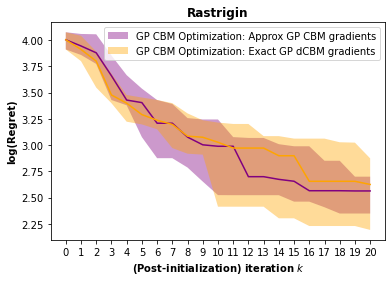

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Purple')
plt.plot(median_exact, color = 'Orange')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Purple', alpha=0.4, label='GP CBM Optimization: Approx GP CBM gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Orange', alpha=0.4, label='GP CBM Optimization: Exact GP dCBM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [99]:
time_approx, time_exact


(126.32969760894775, 668.468465089798)